In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Describe untagged data

In [93]:
#read in untagged content to describe content with no taxons
untagged = pd.read_csv('../../data/untagged_content.csv')

In [94]:
print("There are {} rows in the untagged content data".
      format(untagged.shape[0]))
print("There are {} unique content items in the untagged content data".
      format(untagged.content_id.nunique()))

There are 57337 rows in the untagged content data
There are 57123 unique content items in the untagged content data


In [95]:
untagged.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'taxons', 'title',
       'body'],
      dtype='object')

In [96]:
#convert string dates to timestamp for time series analyses
print(type(untagged['first_published_at'][0]))
untagged['first_published_at'] = pd.to_datetime(untagged['first_published_at'])
print(type(untagged['first_published_at'][0]))

<class 'str'>
<class 'pandas._libs.tslib.Timestamp'>


In [97]:
#use timestamp as index in untagged data for plots
untagged.index = untagged['first_published_at'] 

What's the frequency of publications over time?

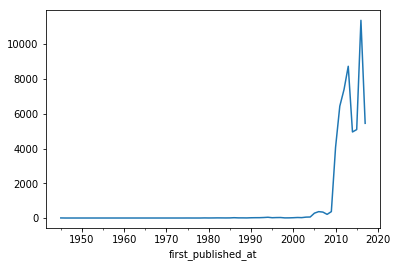

In [98]:
untagged['first_published_at'].resample('Y').count().plot()

Focus: since 2000

(30, 47)

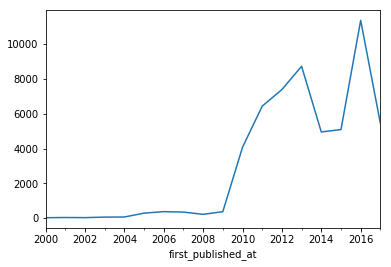

In [99]:
untagged['first_published_at'].resample('Y').count().plot().set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))

What's the publication frequency over time by document type?

In [104]:
grouped = untagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('document_type', fill_value=0)

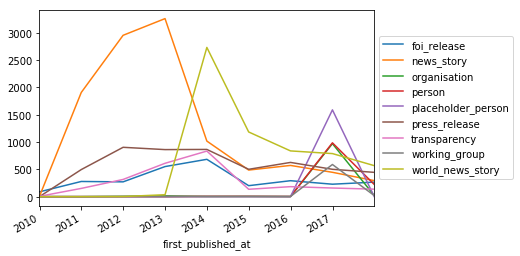

In [105]:
#There are too many document types to plot on one chart so select the types with highest maximum
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [106]:
#ax = grouped.unstack('document_type', fill_value=0).plot()
#ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

in order to compare distribution of document types over time with the labelled data, this needs to be relative not absolute. So change into percent of documents published that year

In [114]:
df = count_by_year.stack().reset_index()
df.columns = ['date', 'document_type', 'percent']
bydoctype_year = df.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

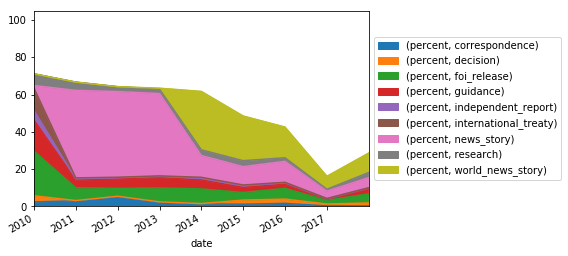

In [115]:

top_pct = bydoctype_pcts.loc[:,bydoctype_pcts.max() > 20]


ax = top_pct.plot(kind='area', stacked=True)
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Import clean content and taxon data

In [5]:
#read in taxon file which was cleaned from raw using clean_taxons.py
taxons = pd.read_csv('../../data/clean_taxons.csv')

In [6]:
taxons.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'taxon_name', 'level1',
       'level2tax_id', 'level3tax_id', 'level4tax_id', 'level1taxon',
       'level2taxon', 'level3taxon', 'level4taxon'],
      dtype='object')

In [7]:
#read in content items file which was cleaned from raw using clean_content.py
#Each row represents a single content-taxon pair. 
#Content items can be paired with multiple taxons
content = pd.read_csv('../../data/clean_content.csv.gz', compression='gzip')

In [8]:
content.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id'],
      dtype='object')

In [9]:
taxons = taxons[['base_path','content_id','taxon_name','level1taxon','level2taxon','level3taxon','level4taxon']]

In [10]:
#For top taxons (level1) ensure that taxon)name is in level1taxon column instead of Nan
taxons['level1taxon'] = taxons['level1taxon'].fillna(taxons['taxon_name'])

### Create a dataset with all taxons represented

In [11]:
allcontent_taxons = pd.merge(
    left=content, 
    right=taxons, 
    left_on='taxon_id', 
    right_on='content_id', 
    how='outer', 
    indicator=True
)

In [12]:
allcontent_taxons.shape

(336967, 23)

In [13]:
allcontent_taxons.rename(columns={'base_path_x': 'base_path', 
                               'content_id_x': 'content_id'}, inplace=True)

In [14]:
#intersection of join only
allcontent_taxons = allcontent_taxons[allcontent_taxons._merge == 'both']

In [15]:
allcontent_taxons.shape

(232526, 23)

In [16]:
#remove duplicates
allcontent_taxons = allcontent_taxons.drop_duplicates(subset = ['content_id', 'taxon_id'])

In [17]:
allcontent_taxons.shape

(232149, 23)

### Remove the taxons that we don't want represented in training/test data

Current approach: Take out World and Corporate top taxons   
Must consider that the data which we will predict on needs to come from the same population as training data and it is hard to filter the unlabelled data to remove World & Corporate (unless they are perfectly predicted by a meta var such as documnet type). It may be safer to keep them in the training data, predict on all data and act differently if World/Corporate is predicted?

In [18]:
taxons.shape

(4530, 7)

In [19]:
taxons = taxons[taxons.level1taxon != 'World']
print("Taxons shape after deleting 'World' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'World' top taxons: (2028, 7)


In [20]:
taxons = taxons[taxons.level1taxon != 'Corporate information']
print("Taxons shape after deleting 'corporate information' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'corporate information' top taxons: (2027, 7)


In [21]:
# Convert nans to taxon_name

taxons['level1taxon'] = taxons['level1taxon'].where(taxons['level1taxon'] != 'nan', None)
taxons['level2taxon'] = taxons['level2taxon'].where(~taxons['level2taxon'].isnull(), None)

print("Taxons shape after converting nans to Nones: {}".format(taxons.shape))

Taxons shape after converting nans to Nones: (2027, 7)


<p style="border-radius: 25px;background: #73AD21;padding: 20px;width: 400px;height: 50px;color: #FFFFFF;">Not sure if still need this as nones??? ☝️☝️☝️☝️☝️</p>

In [22]:
#This could move down into the description of taxons later
mask = ~taxons['level1taxon'].isnull() & taxons['level2taxon'].isnull()

print("There are {} out of {} taxons with a level2"
      .format(sum(~taxons['level2taxon'].isnull()), taxons.shape[0]))
print("There are {} out of {} taxons with a level1 tag, but no level2 tag"
      .format(sum(mask), taxons.shape[0]))

There are 1791 out of 2027 taxons with a level2
There are 236 out of 2027 taxons with a level1 tag, but no level2 tag


## Join the content items with the taxon information

In [23]:
content_taxons = pd.merge(
    left=content, 
    right=taxons, 
    left_on='taxon_id', 
    right_on='content_id', 
    how='outer', 
    indicator=True
)

In [24]:
print(content_taxons['_merge'].value_counts())
print("There are {} tagged content items/taxon combinations with a matching taxon"
      .format(content_taxons['_merge'].value_counts()[2]))
print("There are {} content items/taxon combinations without a matching taxon. Are these untagged content?"
      .format(content_taxons['_merge'].value_counts()[0]))
print("There are {} /taxons with nothing tagged to them"
      .format(content_taxons['_merge'].value_counts()[1]))


both          229461
left_only     106154
right_only       105
Name: _merge, dtype: int64
There are 229461 tagged content items/taxon combinations with a matching taxon
There are 106154 content items/taxon combinations without a matching taxon. Are these untagged content?
There are 105 /taxons with nothing tagged to them


Checkout the left_only content

In [25]:
content_only_taxons = content_taxons[['base_path_x','combined_text','details','taxon_id']][content_taxons._merge == 'left_only']

In [26]:
print("There are {} taxons represented in the {} content item/taxon combinations which have no corresponding taxon in the taxon data"
      .format(content_only_taxons.taxon_id.nunique(), content_only_taxons.shape[0]))

There are 2010 taxons represented in the 106154 content item/taxon combinations which have no corresponding taxon in the taxon data


In [27]:
2010-755

1255

In [28]:
print("There are {} content items/taxon combinations with missing taxon because these were removed during taxon_clean.py"
      .format(content_only_taxons[content_only_taxons.taxon_id.isnull()].shape[0]))

There are 0 content items/taxon combinations with missing taxon because these were removed during taxon_clean.py


In [29]:
content_only_taxons.to_csv('../../data/content_with_taxonid_no_matching_taxon.csv', 
                           index=False)

In [30]:
np.savetxt('../../data/taxonid_no_matching_taxon.gz', 
           content_only_taxons.taxon_id.unique(),fmt='%5s', delimiter=',')

In [31]:
content_taxons.shape

(335720, 23)

In [32]:
content_taxons.head()

,Unnamed: 0,base_path_x,content_id_x,description,details,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,...,variable,taxon_id,base_path_y,content_id_y,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,_merge
0,0.0,/vehicle-tax,fa748fae-3de4-4266-ae85-0797ada3f40c,renew or tax your vehicle for the first time u...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,4.0,/check-vehicle-tax,0889f128-e479-465f-b3e1-a3db6a3879cf,check and report if a vehicle has up-to-date v...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,7.0,/check-mot-history,ad5110e0-fa62-49d3-923f-d50101f12014,check the mot history of a vehicle from 2005 o...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,9.0,/check-mot-status,dc57162b-59f4-4d0f-9b83-a67f74ffccf5,find out the mot test status of a vehicle - ch...,{'will_continue_on': 'the vehicle enquiry serv...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,63.0,/vehicle-tax-refund,fff88e3b-ae66-43e4-afd0-6fc1f227b452,your vehicle tax is cancelled and you get a re...,"{'body': '\n<div class=""summary"">\n<p>Cancel y...",answer,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


## Tidy up columns

In [33]:
content_taxons.columns

Index(['Unnamed: 0', 'base_path_x', 'content_id_x', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id', 'base_path_y', 'content_id_y',
       'taxon_name', 'level1taxon', 'level2taxon', 'level3taxon',
       'level4taxon', '_merge'],
      dtype='object')

In [34]:
content_taxons = content_taxons.drop(['Unnamed: 0', 'variable', 'base_path_y', 
                                      'content_id_y'], axis=1)

In [35]:
content_taxons.rename(columns={'base_path_x': 'base_path', 
                               'content_id_x': 'content_id'}, inplace=True)

## Training data: filter out rows which are duplicates, or mismatches from merge

In [36]:
print("There are {} rows in the data before filtering".
      format(content_taxons.shape[0]))
print("There are {} unique content items in the data before filtering".
      format(content_taxons.content_id.nunique()))
print("There are {} duplicates content items, both with matching content_id "
      "and taxon_id in the data before filtering"
      .format(content_taxons[content_taxons.duplicated(['content_id', 'taxon_id'])].shape[0]))

There are 335720 rows in the data before filtering
There are 140103 unique content items in the data before filtering
There are 956 duplicates content items, both with matching content_id and taxon_id in the data before filtering


In [37]:
# Drop any rows which were not perfectly matched in taxons and content

content_taxons_filtered = content_taxons[content_taxons._merge == 'both']

print("There are {} rows in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.shape[0]))
print("There are {} unique content items in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.content_id.nunique()))

There are 229461 rows in the taxon-level data after filtering out mismatches
There are 127320 unique content items in the taxon-level data after filtering out mismatches


In [38]:
print("There were {} rows dropped because of mismatching"
      .format(content_taxons.shape[0] - content_taxons_filtered.shape[0]))
print("There were {} unique content items dropped because of mismatching"
      .format(content_taxons.content_id.nunique() - content_taxons_filtered.content_id.nunique()))

There were 106259 rows dropped because of mismatching
There were 12783 unique content items dropped because of mismatching


In [39]:
print("There are {} duplicates content items, both with matching"
      "content_id and taxon_id in after removing mismatches"
      .format(content_taxons_filtered[content_taxons_filtered.
                                      duplicated(['content_id', 'taxon_id'])].shape[0]))

There are 377 duplicates content items, both with matchingcontent_id and taxon_id in after removing mismatches


In [40]:
content_taxons_dedup = content_taxons_filtered.drop_duplicates(subset = ['content_id', 'taxon_id'])

In [41]:
#assert content_taxons_dedup.shape == (2029084, 18)
content_taxons_dedup.shape

(229084, 19)

In [42]:
content_taxons_dedup.head()

,base_path,content_id,description,details,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,combined_text,taxon_id,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,_merge
5,/student-finance-register-login,e57daef4-5eb5-431c-b0ad-14119ab0355f,your student finance online account - check pa...,{'will_continue_on': 'the Student Finance Engl...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,student finance login,,student finance login your student finance onl...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
6,/student-finance,d38bafd3-2c46-4be2-b50b-50c2ba7d30ed,student finance - student loans or student gra...,{'external_related_links': [{'title': 'Student...,guide,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,student finance,,student finance student finance - student loan...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
7,/contact-student-finance-england,d490be5f-1998-4f20-ab52-d3dd5db7fa71,contact details for student finance england - ...,"{'body': '\n<div class=""summary"">\n<p>Contact ...",answer,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,contact student finance england,contact details for student finance england in...,contact student finance england contact detail...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
8,/student-finance-calculator,434b6eb5-33c8-4300-aba3-f5ead58600b8,student finance calculator - get a quick estim...,"{'start_button_text': 'Start now', 'transactio...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,smartanswers,student finance calculator,,student finance calculator student finance cal...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
9,/apply-online-for-student-finance,83155b50-418e-437c-9389-cf0e1302900f,apply online for student finance - online appl...,{'will_continue_on': 'the Student Finance Engl...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,apply online for student finance,,apply online for student finance apply online ...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both


In [43]:
print("There were {} additional rows dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.shape[0] - content_taxons_dedup.shape[0]))
print("There were {} additional content items dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.content_id.nunique() - content_taxons_dedup.content_id.nunique()))

There were 377 additional rows dropped due to duplicate content_id/taxon_id combination
There were 0 additional content items dropped due to duplicate content_id/taxon_id combination


## Top level taxons

Expecting 19 top taxons (plus `None`)

In [44]:
assert content_taxons_dedup.level1taxon.nunique() == 19

print("There are {} unique taxon names in the level 1 taxon"
      .format(content_taxons_dedup.level1taxon.nunique()))

set(content_taxons_dedup.level1taxon)

There are 19 unique taxon names in the level 1 taxon


{'Business',
 'Crime, justice and law',
 'Defence',
 'Education, training and skills',
 'Entering and staying in the UK',
 'Environment',
 'Going and being abroad',
 'Government',
 'Health and social care',
 'Housing, local and community',
 'International',
 'Life circumstances',
 'Money',
 "Parenting, childcare and children's services ",
 'Regional and local government',
 'Society and culture',
 'Transport',
 'Welfare',
 'Work'}

In [45]:
topfreq = content_taxons_dedup.groupby('level1taxon').size()
topfreq.sort_values(ascending=False)

level1taxon
Business                                         48397
Environment                                      29199
Government                                       23809
Society and culture                              15476
Health and social care                           14886
Money                                            13722
International                                    13409
Housing, local and community                     10637
Defence                                          10363
Crime, justice and law                            9998
Education, training and skills                    9790
Regional and local government                     9065
Transport                                         8468
Work                                              5132
Welfare                                           3164
Going and being abroad                            1841
Parenting, childcare and children's services      1122
Entering and staying in the UK                     31

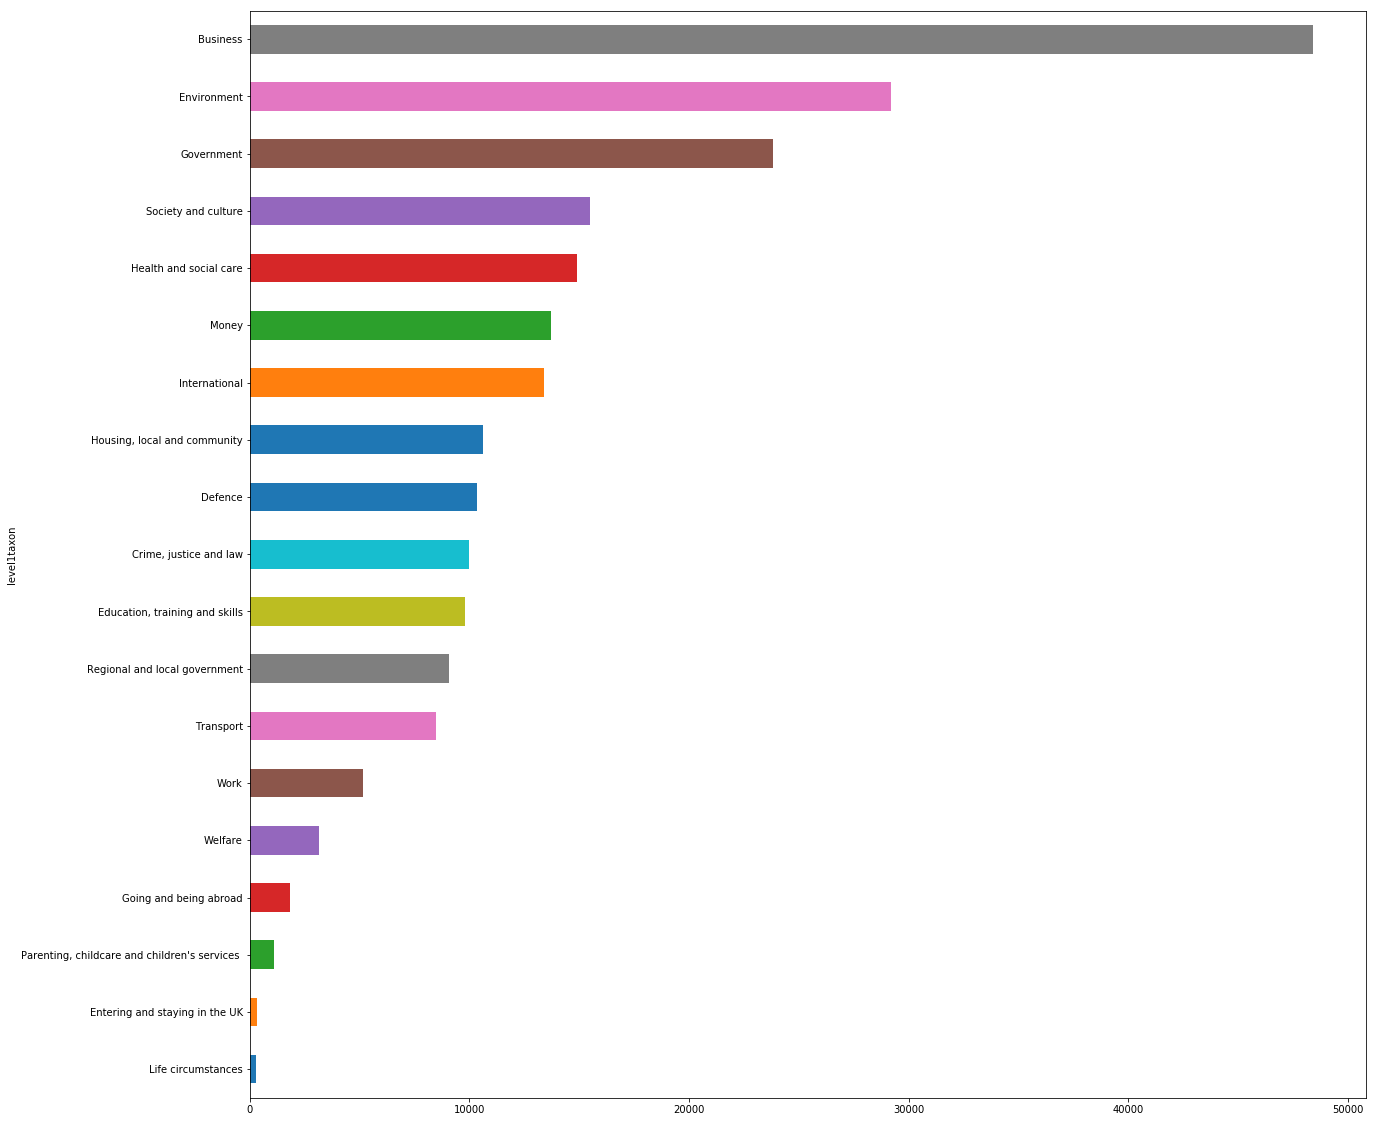

In [46]:
topfreq.sort_values().plot(kind = 'barh', figsize=(20, 20))

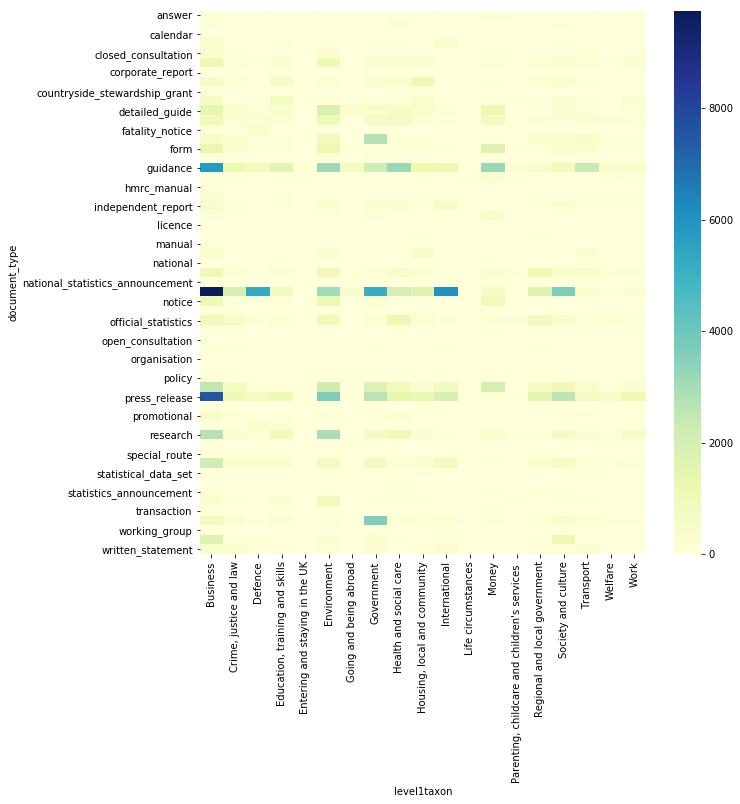

In [47]:
top_doctype = pd.crosstab(content_taxons_dedup['document_type'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(top_doctype, cmap = "YlGnBu")

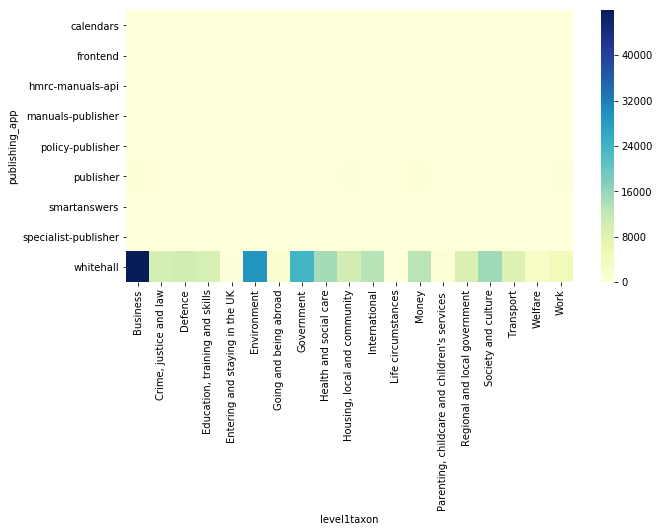

In [48]:
top_pubapp = pd.crosstab(content_taxons_dedup['publishing_app'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(top_pubapp, cmap = "YlGnBu")

In [49]:
content_taxons_dedup.groupby('level1taxon').size().sort_values(ascending=False)

level1taxon
Business                                         48397
Environment                                      29199
Government                                       23809
Society and culture                              15476
Health and social care                           14886
Money                                            13722
International                                    13409
Housing, local and community                     10637
Defence                                          10363
Crime, justice and law                            9998
Education, training and skills                    9790
Regional and local government                     9065
Transport                                         8468
Work                                              5132
Welfare                                           3164
Going and being abroad                            1841
Parenting, childcare and children's services      1122
Entering and staying in the UK                     31

### Level 2 taxons

In [50]:
#assert content_taxons_dedup.level2taxon.nunique() == 103

print("There are {} unique taxon names in the level 2 taxon"
      .format(content_taxons_dedup.level2taxon.nunique()))

There are 103 unique taxon names in the level 2 taxon


In [51]:
second_freq = content_taxons_dedup.groupby('level2taxon').size().sort_values(ascending=False)

# Print as string to get around truncation

print(second_freq.to_string())



level2taxon
Foreign affairs                                                           5447
Climate change and energy                                                 4250
Business and enterprise                                                   3705
Trade and investment                                                      3487
Housing planning and building                                             2676
International aid and development                                         2618
School curriculum                                                         2492
Business tax                                                              2417
Housing                                                                   2148
Rail                                                                      2100
Dealing with HMRC                                                         1805
Business and the environment                                              1710
Maritime                                

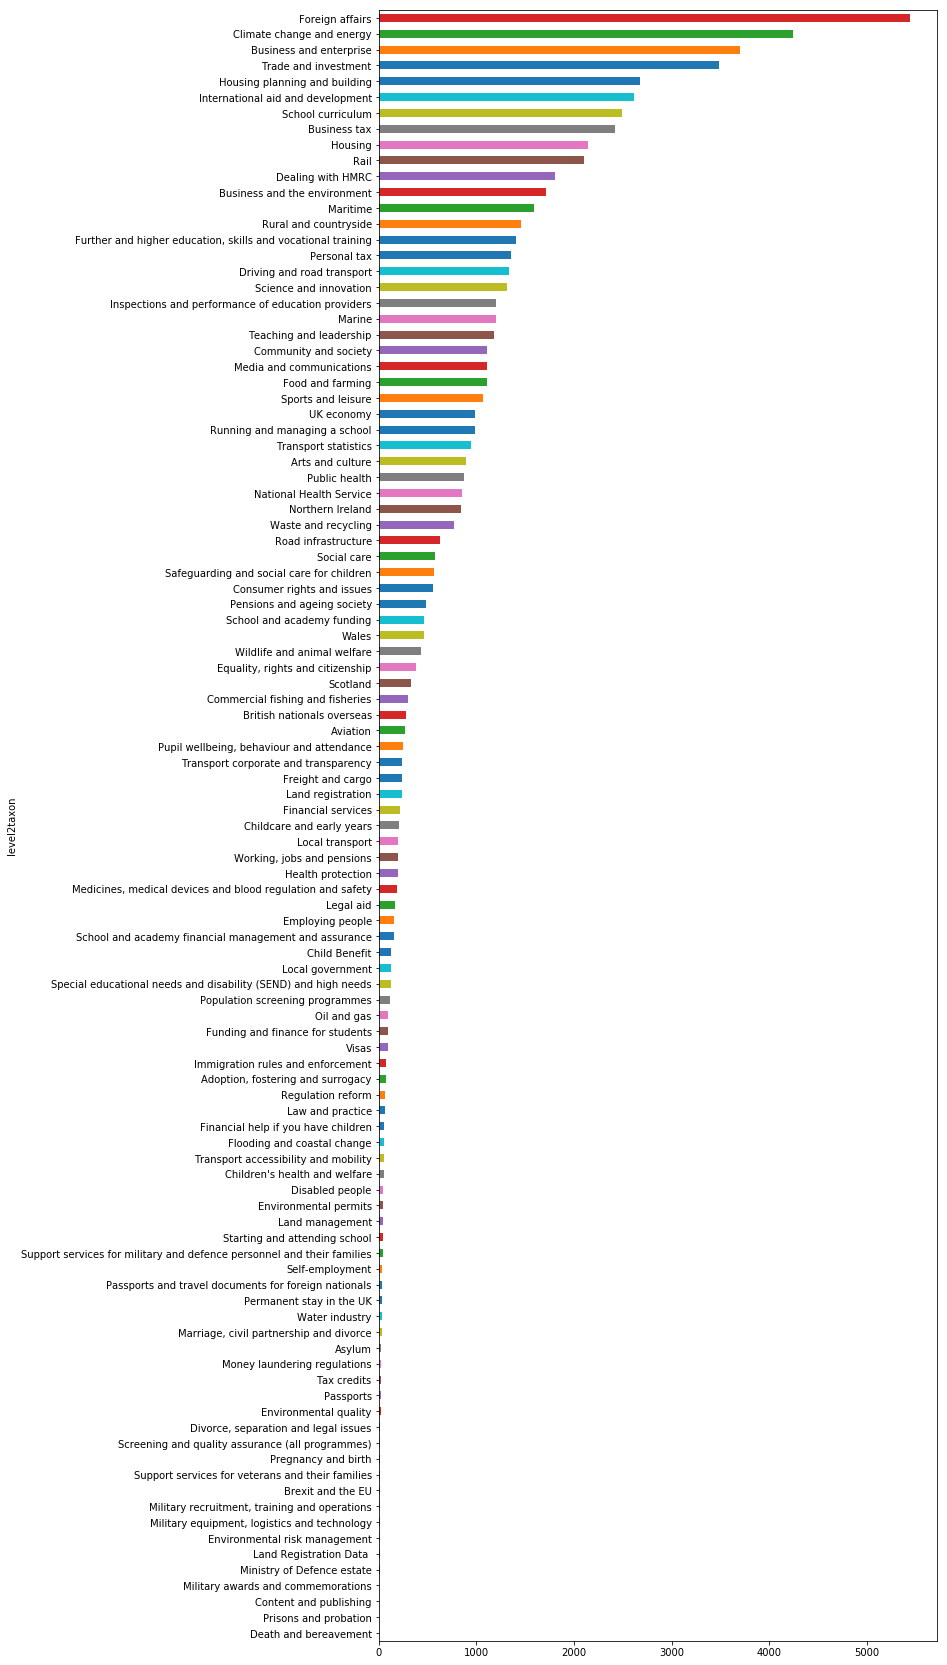

In [52]:
second_freq.sort_values().plot(kind = 'barh', figsize=(10,30))

## How much stuff is only tagged to level 1?

In [53]:
mask = ~content_taxons_dedup['level1taxon'].isnull() & content_taxons_dedup['level2taxon'].isnull()

print("There are {} out of {} content items with no level1 tag"
      .format(sum(content_taxons_dedup['level1taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level2 tag"
      .format(sum(~content_taxons_dedup['level2taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level1 tag, but no level2 tag"
      .format(sum(mask), content_taxons_dedup.shape[0]))

There are 0 out of 229084 content items with no level1 tag
There are 68678 out of 229084 content items with a level2 tag
There are 160406 out of 229084 content items with a level1 tag, but no level2 tag


In [54]:
content_taxons_dedup['level1taxon'].head()

5    Education, training and skills
6    Education, training and skills
7    Education, training and skills
8    Education, training and skills
9    Education, training and skills
Name: level1taxon, dtype: object

In [55]:
mask = ~content_taxons_dedup['level1taxon'].isnull() & content_taxons_dedup['level2taxon'].isnull()

print("There are {} out of {} content items with no level1 tag"
      .format(sum(content_taxons_dedup['level1taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level2 tag"
      .format(sum(~content_taxons_dedup['level2taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level1 tag, but no level2 tag"
      .format(sum(mask), content_taxons_dedup.shape[0]))

There are 0 out of 229084 content items with no level1 tag
There are 68678 out of 229084 content items with a level2 tag
There are 160406 out of 229084 content items with a level1 tag, but no level2 tag


## Checking that all items tagged to lower level have a label in toptaxon and secondtaxon

In [56]:
level1_2 = pd.crosstab(content_taxons_dedup['level1taxon'], content_taxons_dedup['level2taxon'])

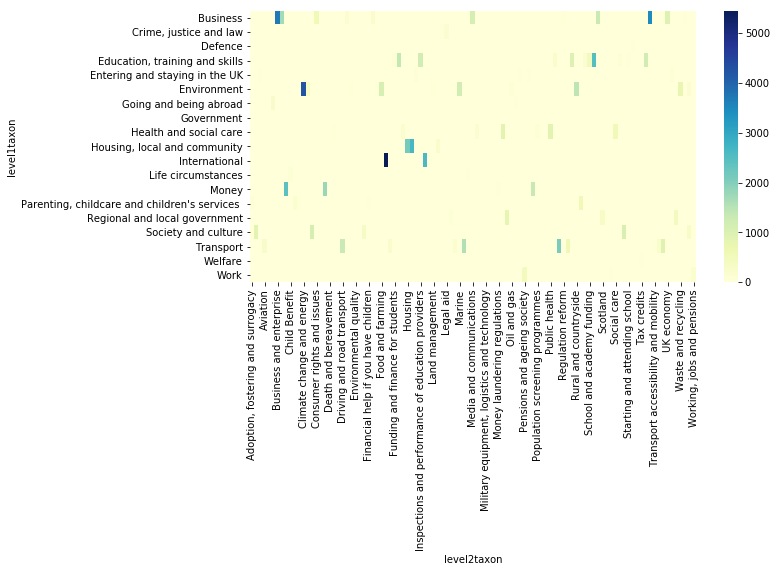

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(level1_2, cmap = "YlGnBu")

In [58]:
print('There are {} missing level2taxons (which we need to predict) out of a total {} content items.'
      .format(sum(content_taxons_dedup['level2taxon'].isnull()), 
              len(content_taxons_dedup['level2taxon'].isnull())))

There are 160406 missing level2taxons (which we need to predict) out of a total 229084 content items.


## Compare untagged, raw tagged, deduped-filtered tagged

the untagged content appears to have a different distribution of document type compared to the tagged content, both before and after filtering the World/Corporate categories and deduplication. 

For example, relatively few guidance , policy paper and research documents are untagged. World_news_story, foi releases are over-represented in untagged data compared to tagged data.

This is likely to result in a drop inaccuracy when moving from modelling data to predicting for untagged data.

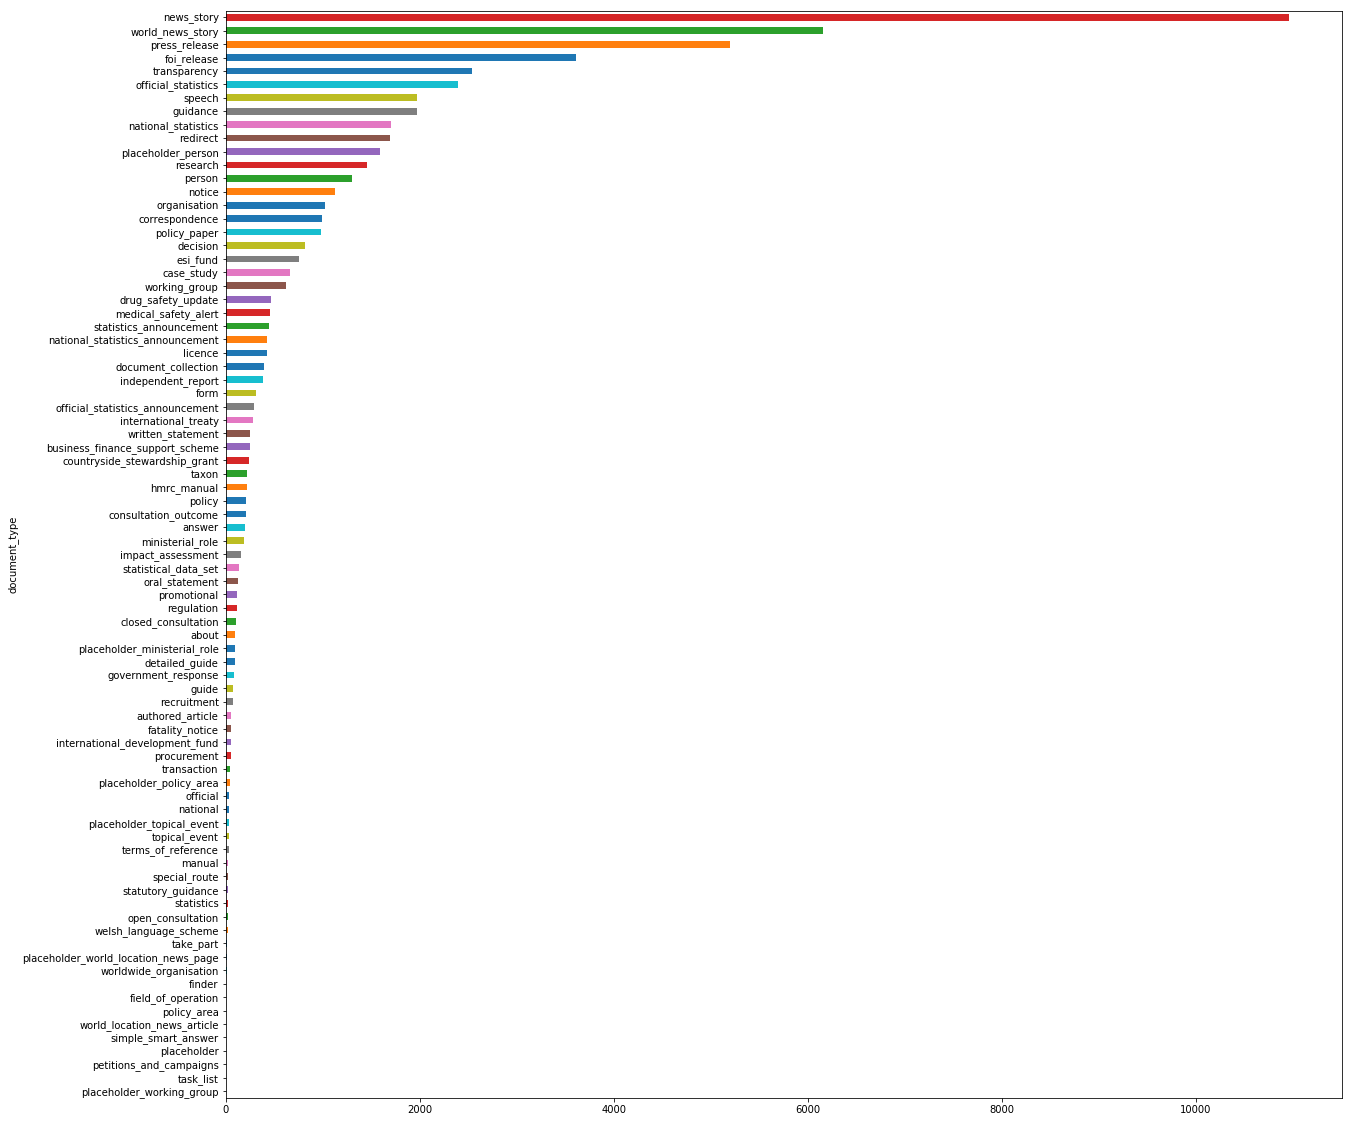

In [59]:
untagged.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

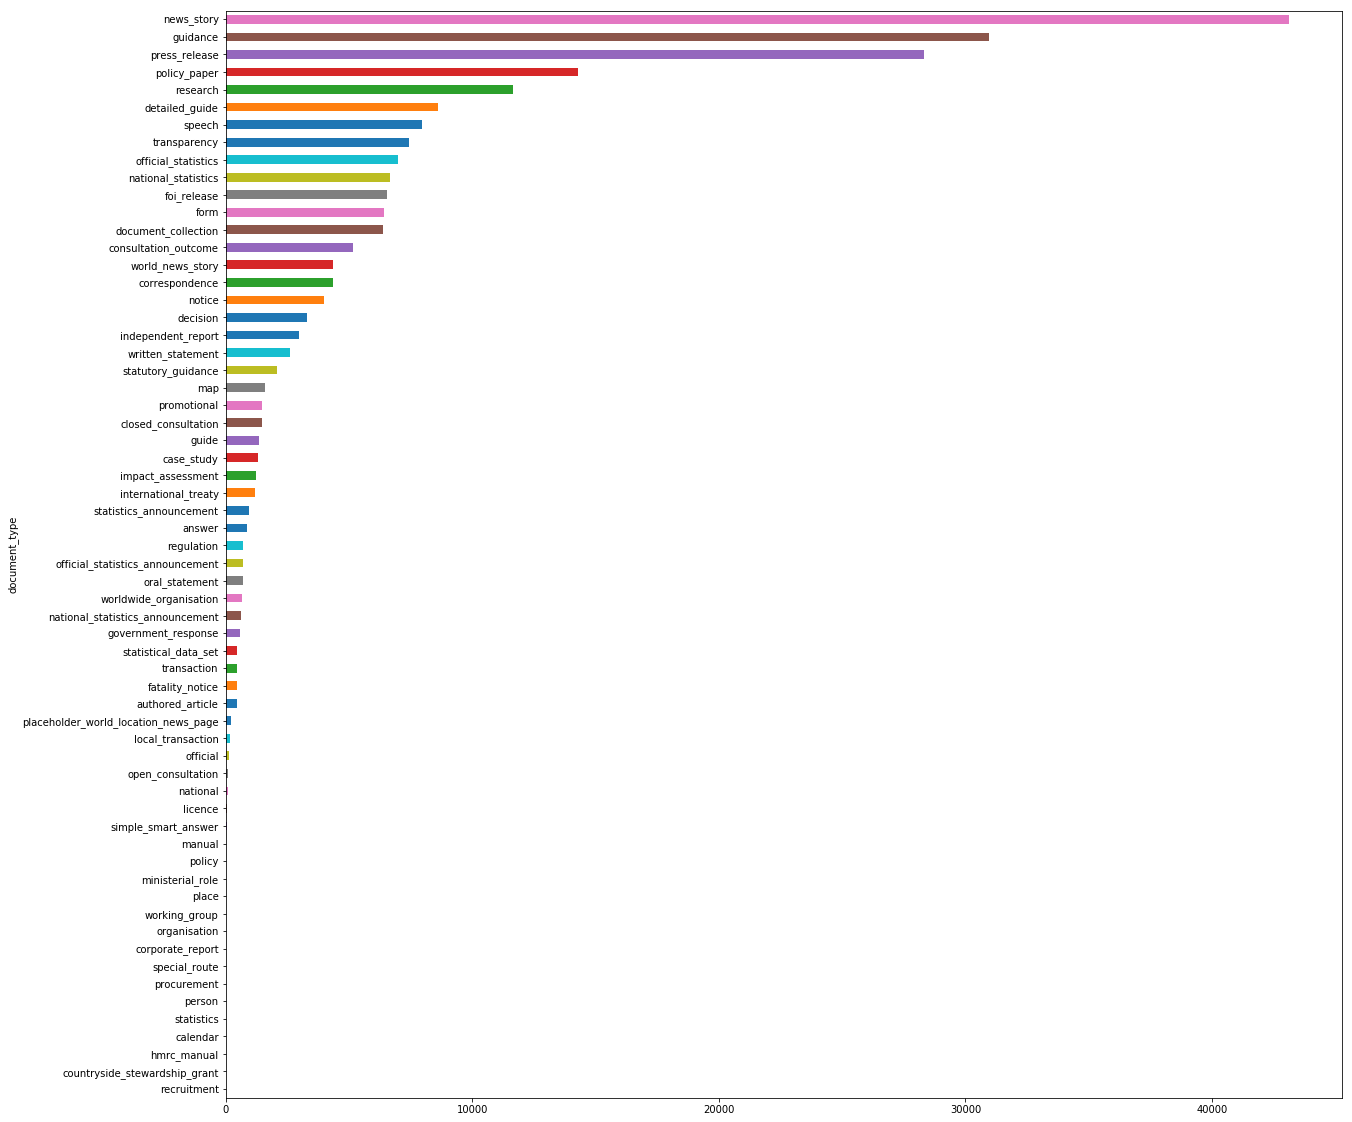

In [60]:
allcontent_taxons.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

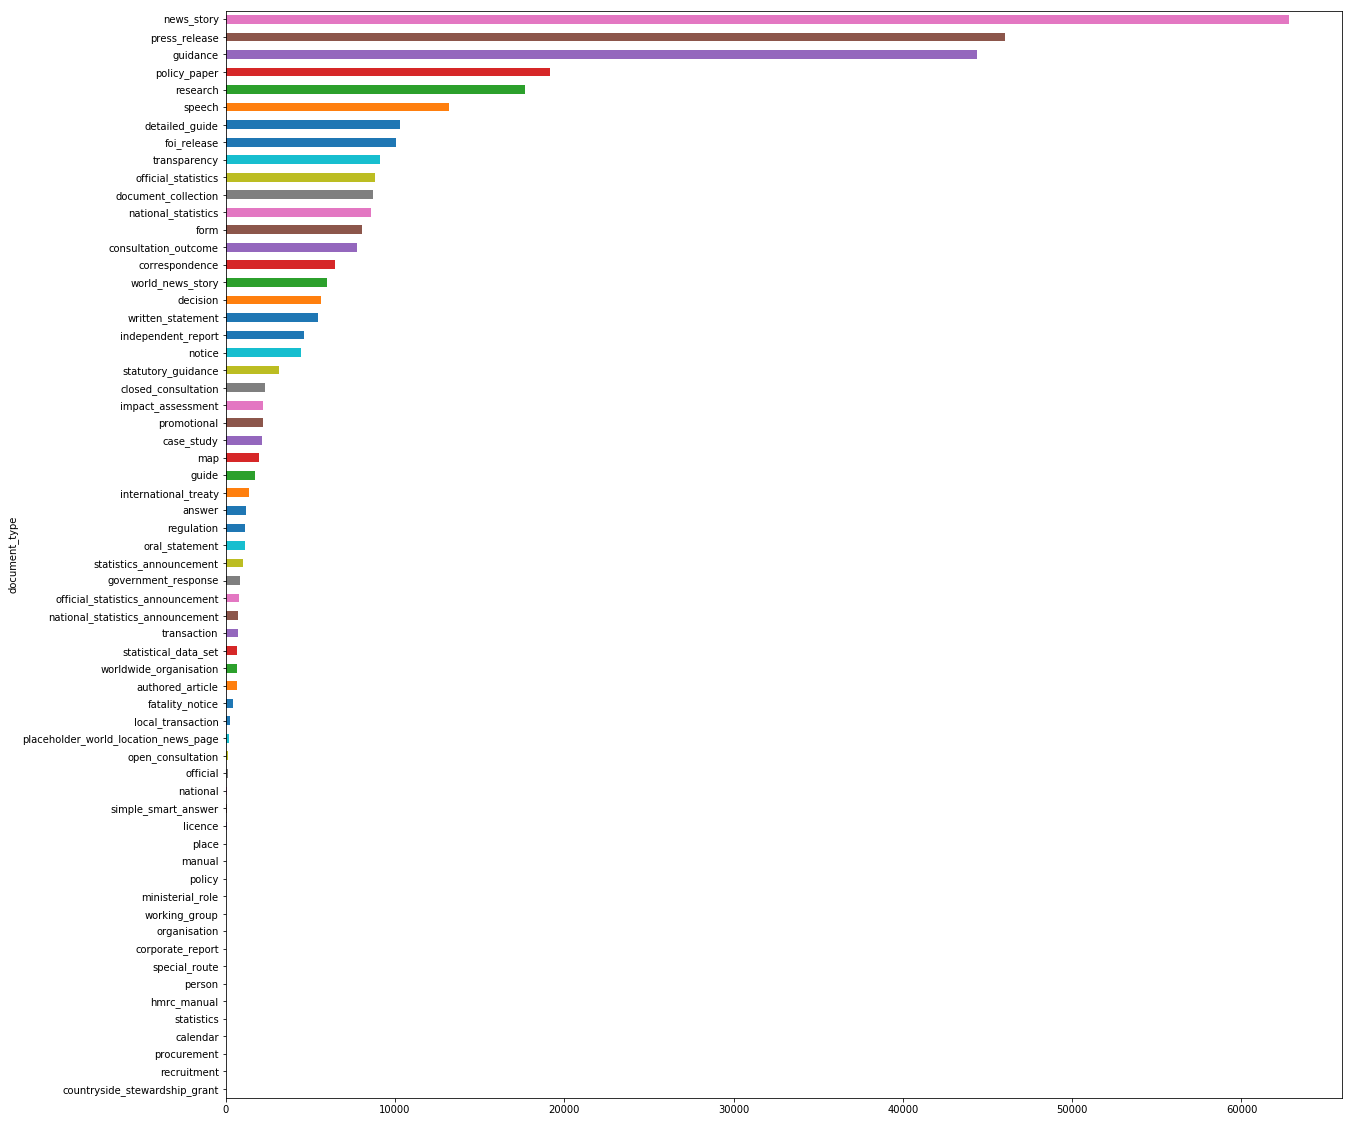

In [61]:
content.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

In [63]:
type(untagged['first_published_at'][0])

str

In [64]:
untagged['first_published_at'][0]

'2016-02-29T09:24:10.000+00:00'

In [66]:
pd.to_datetime(untagged['first_published_at'][0])

Timestamp('2016-02-29 09:24:10')